In [2]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from anatomy.anatomy_api import AnatomyApi
from primary_injection_structure import get_primary_injection_structure
sns.set_context('poster')
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
from matplotlib import ticker

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [5]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(
    manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
#cla = structure_tree.get_structures_by_acronym(['CLA'])[0]['id']
#HPF = structure_tree.get_structures_by_acronym(['HPF'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
#hipp = structure_tree.descendant_ids([HPF['id']])[0]
#hipp = [structure for structure in hipp if structure in ss]
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key, value in ia_map.items()}
ctx_strs = [ai_map[structure] for structure in iso]
#hipp_strs = [ai_map[structure] for structure in hipp]
valid_strs = ctx_strs

In [7]:
plot_order = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 
              'RSPagl', 'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs',
              'SSs', 'SSp-bfd', 'SSp-ul', 'SSp-un', 'SSp-n', 'SSp-m', 'MOp',
              'FRP', 'VISpm', 'AId', 'AIv', 'AIp', 'GU', 'VISC', 'TEa', 'PERI', 'ECT', 
              'VISal', 'VISl', 
              'VISp', 'VISpl', 'VISli', 'VISpor', 'VISrl', 'AUDd', 'AUDp', 'AUDpo', 'AUDv']
ids = [ia_map[structure] for structure in plot_order]
print(len(ids))

43


In [8]:
import platform
if platform.system() == 'Darwin':
    path = '/Users/jenniferwh/Dropbox/DMN paper/centroid_distances'
    savepath = '/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/Figure_S6'
    dmn_score = pd.read_csv(
        r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/target_defined_dataset.csv')
if platform.system() == 'Windows':
    path = r'C:\Users\jenniferwh\Dropbox\DMN paper\centroid_distances'
    savepath = r'C:\Users\jenniferwh\Dropbox\DMN data\projection matrices'
    dmn_score = pd.read_csv(
        r"C:\Users\jenniferwh\Dropbox (Allen Institute)\Mesoscale Connectome Papers in Progress\2019 DMN\target_defined_dataset.csv")

dmn_score = dmn_score[dmn_score['include'] == 'yes']

In [9]:
dat = pd.read_csv(r'/Users/jenniferwh/Dropbox/DMN data/correlations/good_td_wt_correlations.csv')
print(len(dat))

930


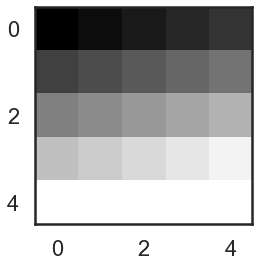

In [10]:
my_cmap = cm.get_cmap('gray')
my_cmap.set_over('white')
plt.imshow(np.arange(25).reshape(5, 5), interpolation='none', cmap=my_cmap, vmax=20)

row_labels = ['0', '1', '2', '3', '4']
row_labels = np.array(row_labels)
sorted_index = np.argsort(row_labels)
new_index = np.copy(sorted_index)
print(sorted_index)
for ix in np.arange(len(new_index)):
    print(ix)
    if (ix > 1):
        new_index[ix] = ix-1
new_index[1] = sorted_index[-1]
print(new_index)

In [12]:
experiments = mcc.get_experiments(dataframe=True, cre=False, injection_structure_ids = ids)
print(len(experiments))

129


rostral_rspv = [605496542, 616674416, 475830603, 524063357, 561512675, 475828414, 561910766, 525412369]
matched_rspvc = [569904687, 561511939, 521255975, 623838656, 592522663, 666090944, 592724077, 664716091]
dorsal_rspvc = [555012592, 561307215, 570071403, 571647261]
'''
ACAd1 = [477435412, 637855050, 649362978]
ACAd2 = [528741104, 601359621, 607321130, 571401645, 609475867, 475829896]
ACAd3 = [567301515, 607059419]
'''
dmn_score.loc[dmn_score['id'].isin(rostral_rspv), 'source'] = 'RSPv r'
dmn_score.loc[dmn_score['id'].isin(dorsal_rspvc), 'source'] = 'dorsal RSPv c'
dmn_score.loc[dmn_score['id'].isin(matched_rspvc), 'source'] = 'matched RSPv c'
'''
dmn_score.loc[dmn_score['id'].isin(ACAd1), 'source'] = 'ACAd-1'
dmn_score.loc[dmn_score['id'].isin(ACAd2), 'source'] = 'ACAd-2'
dmn_score.loc[dmn_score['id'].isin(ACAd3), 'source'] = 'ACAd-3'
dmn_score.loc[dmn_score['id'] == 607052300, 'source'] = 'ACAv-2'
'''
dmn_score.loc[dmn_score['id'] == 531443949, 'source'] = 'RSPv c'

In [13]:
source = 'ACAv'
label = 'ORBvl'
dmn_score[(dmn_score['source'] == source) & 
                                  (dmn_score['target_by_projection'] == label)]['CAV_percent_DMN'].values[0]

98.37251624

In [33]:
def make_projection_matrix(source, td_dat, wt=False, average=False, threshold = 10**(-1.5)):
    data_type = 'normalized_projection_volume'
    '''
    if len(wt) > 0:
        if(len(wt) > 1):
            average = True
        else:
            average = False
    '''
    pm_wt = get_projection_matrix(experiment_ids = wt, 
                                  projection_structure_ids = ids,
                                  hems= dat[dat['match_id'].isin(wt)]['match_injection_hem'].values,
                                  parameter = data_type,
                                  average = average)
    pm_td = get_projection_matrix(experiment_ids = td_dat['image_series_id'], 
                                  projection_structure_ids = ids,
                                  hems= [1], # left hemisphere, ipsilateral
                                  parameter = data_type)

    targets = [td_dat[td_dat['image_series_id'] == isid]['target_by_polygon'].values 
               for isid in td_dat['image_series_id'].values]
    expt_ids = np.concatenate([pm_wt['rows'], [np.nan], pm_td['rows']]) 
    epsilon = np.min(pm_wt['matrix'])/2
    index = 2
    while np.log10(epsilon) < -6:
        epsilon = np.partition(pm_wt['matrix'], index)[0][1]/2
        index += 1

    if average:
        row_labels = ['wt (n=%s)'%len(wt)] * len(pm_wt['rows']) + [""] + list(td_dat['target_by_polygon'].values)
    else:  
        row_labels = ['wt (n=1)'] * len(pm_wt['rows']) + [""] + list(td_dat['target_by_polygon'].values)
    row_labels = np.array(row_labels)
    matrix = np.concatenate((np.log10(pm_wt['matrix']+epsilon), 
                             np.ones_like(pm_wt['matrix'])*threshold,
                             np.log10(pm_td['matrix']+epsilon)), axis = 0)
    new_matrix = matrix[:2]
    new_row_labels = row_labels[:2]
    for label in row_labels:
        if len(row_labels[row_labels == label]) > 1:
            if label not in new_row_labels:
                label_n = label + ' (n=%s)'%len(row_labels[row_labels == label])
                if label_n not in new_row_labels:
                    new_row_labels = np.concatenate((new_row_labels, [label_n]))
                    mean_by_target = np.mean(matrix[np.where(row_labels == label)], axis = 0)
                    mean_by_target = np.hstack([mean_by_target.reshape(len(np.where(row_labels == label)),-1)])
                    new_matrix = np.concatenate((new_matrix, mean_by_target))
        else:
            if label not in new_row_labels:
                new_row_labels = np.concatenate((new_row_labels, [label + ' (n=1)']))
                new_matrix = np.concatenate((new_matrix, matrix[np.where(row_labels == label)]))
    # sort index by CAV DMN fraction
    scores = {}
    for label in new_row_labels:
        if label[:-6] in dmn_score['target_by_polygon'].values:
            score = dmn_score[(dmn_score['source'] == source) & 
                              (dmn_score['target_by_polygon'] == label[:-6])]['CAV_percent_DMN'].mean()
            if not pd.isnull(score):
                scores[label] = int(score)+1
        elif label[:-6] == 'wt':
            scores[label] = 0
        elif label[:-7] == 'wt': #when there are more than 9 wt
            scores[label] = 0
        elif label[:-6] == "":
            scores[label] = 0.1
    sorted_row_labels = sorted(scores, key=scores.get)
    new_index = []
    CAV_fraction_labels = []
    for label in sorted_row_labels:
        for index, old_label in enumerate(new_row_labels):
            if old_label == label:
                new_index.append(index)
                CAV_fraction_labels.append(int(scores[label]-1))
    new_index = np.flipud(new_index)
    new_row_labels = np.flipud(sorted_row_labels)
    CAV_fraction_labels = np.flipud(CAV_fraction_labels)
    column_labels = [ c['label'] for c in pm_td['columns'] ] 
    new_matrix[np.isnan(new_matrix)] = 0
    new_matrix[np.where(new_matrix < threshold)] = threshold
    new_matrix = new_matrix[new_index]
    # Set all the CAV targets to the maximum value + 1
    maxval = new_matrix.max()
    for index,row in enumerate(new_matrix):
        try:
            target_index = column_labels.index(new_row_labels[index][:-6]) # for labels containing n=x, x>9
            row[target_index] = maxval + (10^-1.5)/2
        except: # this clause is for wt
            pass
    plot_matrix(source, data_type, epsilon, new_matrix, new_row_labels, column_labels, CAV_fraction_labels)

def get_projection_matrix(experiment_ids, 
                          projection_structure_ids=None,
                          hems=None, 
                          parameter='normalized_projection_volume', 
                          average = False):
    if len(hems) > 1 and len(hems) == len(experiment_ids):
        hemkey = dict(zip(experiment_ids, hems))
        r = [key for key in hemkey.keys() if hemkey[key] == 2]
        if len(r) > 0:
            r_unionizes = mcc.get_structure_unionizes(r,
                                                 is_injection=False,
                                                 structure_ids=projection_structure_ids,
                                                 include_descendants=False,
                                                 hemisphere_ids=[2])
            l = [key for key in hemkey.keys() if hemkey[key] == 1]
            if len(l) > 0:
                l_unionizes = mcc.get_structure_unionizes(l, 
                                                      is_injection=False,
                                                     structure_ids=projection_structure_ids,
                                                     include_descendants=False,
                                                     hemisphere_ids=[1])
                l_unionizes['hemisphere_id'] = 2
                unionizes = pd.concat([r_unionizes, l_unionizes])
            else:
                unionizes = r_unionizes
        else:
            unionizes = mcc.get_structure_unionizes(experiment_ids, 
                                              is_injection=False,
                                             structure_ids=projection_structure_ids,
                                             include_descendants=False,
                                             hemisphere_ids=[1])
    else:
        unionizes = mcc.get_structure_unionizes(experiment_ids, 
                                              is_injection=False,
                                             structure_ids=projection_structure_ids,
                                             include_descendants=False,
                                             hemisphere_ids=[1])
    hemisphere_ids = unionizes['hemisphere_id'].unique()
    nrows = len(experiment_ids)
    ncolumns = len(projection_structure_ids) * len(hemisphere_ids)

    matrix = np.empty((nrows, ncolumns))
    matrix[:] = np.NAN

    row_lookup = {}
    for idx, e in enumerate(experiment_ids):
        row_lookup[e] = idx

    column_lookup = {}
    columns = []

    cidx = 0

    acronym_map = mcc.get_structure_tree().value_map(lambda x: x['id'], 
                                                      lambda x: x['acronym'])

    for hid in hemisphere_ids:
        for sid in projection_structure_ids:
            column_lookup[(hid, sid)] = cidx
            label = acronym_map[sid]
            columns.append(
                {'hemisphere_id': hid, 'structure_id': sid, 'label': label})
            cidx += 1

    for _, row in unionizes.iterrows():
        ridx = row_lookup[row['experiment_id']]
        k = (row['hemisphere_id'], row['structure_id'])
        cidx = column_lookup[k]
        matrix[ridx, cidx] = row[parameter]   
        
    if average:
        matrix = matrix.mean(axis = 0)
        matrix = np.hstack([matrix.reshape(len(projection_structure_ids),-1)]).T
        experiment_ids = ['average']
    return {'matrix': matrix, 'rows': experiment_ids, 'columns': columns}
    
def plot_matrix(source, data_type, epsilon, matrix, row_labels, column_labels, 
                CAV_fraction_labels):
    #threshold = 0.0001
    my_cmap = cm.get_cmap('Greys')
    rl = [label[:-6] for label in row_labels]
    row_index = dict(zip(rl, np.arange(len(row_labels))))
    column_index = dict(zip(column_labels, np.arange(len(column_labels))))
    matrix_max = np.max(matrix)
    for row in rl:
        try:
            matrix[row_index[row], column_index[row]] = 10
        except:
            continue
    my_cmap.set_over('r')
    fig, ax = plt.subplots(figsize=(8,len(matrix)/5.5))
    heatmap = ax.pcolor(matrix, cmap=my_cmap, vmin=threshold, vmax = matrix_max)
    # heatmap = ax.pcolor(matrix, cmap=my_cmap, vmax = np.max(matrix)-0.00001)
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

    ax.set_xlim([0, matrix.shape[1]])
    ax.set_ylim([0, matrix.shape[0]])   

    # want a more natural, table-like display
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)

    ax.set_xticklabels(column_labels, minor=False, fontsize = 10)
    ax.set_yticklabels(row_labels, minor=False, fontsize = 10)

    cbar = fig.colorbar(heatmap, ax = ax, orientation='vertical', fraction=0.046, pad=0.08)
    cbar_ax = fig.axes[-1]
    cbar_solids = cbar_ax.collections[0]
    cbar_solids.set_edgecolor("face")
    tick_locator = ticker.MaxNLocator(nbins=len(matrix))
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=10)
    cbar.locator = tick_locator
    cbar.update_ticks()
    
    ax2 = ax.twinx()
    ax2.set_yticks(np.arange(matrix.shape[0])+0.3, minor=False)
    ax2.set_yticklabels(CAV_fraction_labels, fontsize = 10)
    ax2.tick_params(axis='y', which='major', pad=5)
    
    ax.text(1.01, 1.5, 'CAV\npercent\nDMN',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=12)
    
    __file__ = os.path.join(savepath, '%s_matrix_by_dmn_%s_epsilon_%s_threshold_%s'%(source, data_type, epsilon, threshold))
    plt.savefig(__file__+".pdf", bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=1000)
    plt.show()

In [23]:
savepath

'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/Figure_S6'

# Plot matrices for one source

ACAd
11


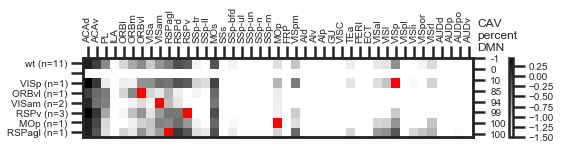

In [24]:
threshold = -1.5
source_structure = 'ACAd'
print(source_structure)
source_dat = dmn_score[dmn_score['source'] == source_structure]
td_dat = dmn_score[dmn_score['source'] == source_structure][['image_series_id', 
                                                             'target_by_polygon']]
wt_ids = np.unique(dat[dat['source'] == source_structure]['match_id'])
if len(wt_ids) > 1:
    print(len(wt_ids))
    average = True
make_projection_matrix(source_structure, td_dat, wt_ids, True, threshold)

ORBl
2


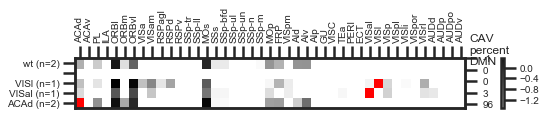

In [35]:
threshold = -1.5
source_structure = 'ORBl'
print(source_structure)
source_dat = dmn_score[dmn_score['source'] == source_structure]
td_dat = dmn_score[dmn_score['source'] == source_structure][['image_series_id', 
                                                             'target_by_polygon']]
wt_ids = np.unique(dat[dat['source'] == source_structure]['match_id'])
if len(wt_ids) > 1:
    print(len(wt_ids))
    average = True
make_projection_matrix(source_structure, td_dat, wt_ids, True, threshold)

# Make matrices for all sources

In [13]:
dat['source'].unique()

array(['VISp', 'RSPv', 'ACAv', 'MOs', 'ORBl', 'VISl', 'ORBvl', 'ACAd',
       'ENTm', 'MD', 'RSPagl', 'ENTl', 'ECT', 'RSPd', 'AM', 'ORBm',
       'VISam', 'AIv', 'SSp-tr', 'VISli', 'PL', 'ILA', 'RE', 'VISpm',
       'VISa', 'AV', 'VISpl', 'VISrl', 'SSp-ll', 'VISal', 'TEa', 'VISpor',
       'CLA'], dtype=object)

rostral_rspv = [605496542, 616674416, 475830603, 524063357, 561512675, 475828414, 561910766, 525412369]
matched_rspvc = [569904687, 561511939, 521255975, 623838656, 592522663, 666090944, 592724077, 664716091]
dorsal_rspvc = [555012592, 561307215, 570071403, 571647261]
'''
ACAd1 = [477435412, 637855050, 649362978]
ACAd2 = [528741104, 601359621, 607321130, 571401645, 609475867, 475829896]
ACAd3 = [567301515, 607059419]
'''
dat.loc[dat['id'].isin(rostral_rspv), 'source'] = 'RSPv r'
dat.loc[dat['id'].isin(dorsal_rspvc), 'source'] = 'dorsal RSPv c'
dat.loc[dat['id'].isin(matched_rspvc), 'source'] = 'matched RSPv c'
'''
dat.loc[dat['id'].isin(ACAd1), 'source'] = 'ACAd-1'
dat.loc[dat['id'].isin(ACAd2), 'source'] = 'ACAd-2'
dat.loc[dat['id'].isin(ACAd3), 'source'] = 'ACAd-3'
'''
dat.loc[dat['id'] == 607052300, 'source'] = 'ACAv-2'
dat.loc[dat['id'] == 531443949, 'source'] = 'RSPv c'

<h2>VISp</h2>

58


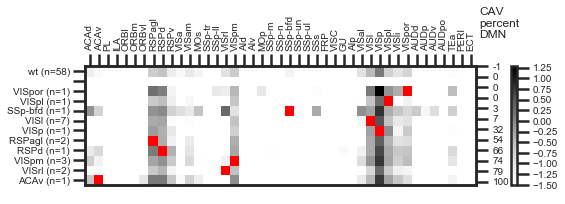

<h2>RSPv</h2>

9


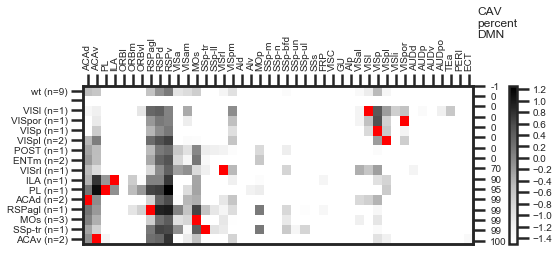

<h2>ACAv</h2>

4


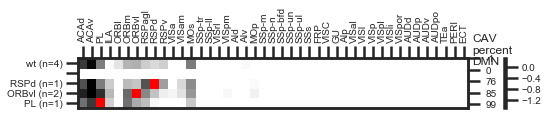

<h2>MOs</h2>

7


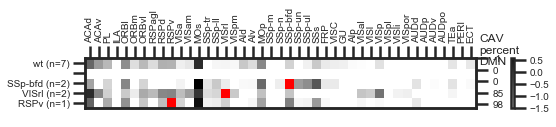

<h2>ORBl</h2>

2


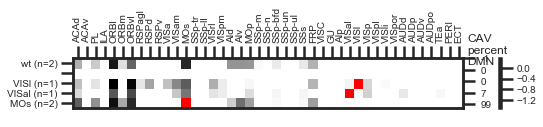

<h2>VISl</h2>

10


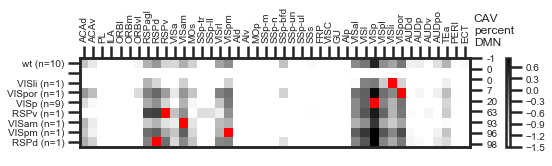

<h2>ORBvl</h2>

5


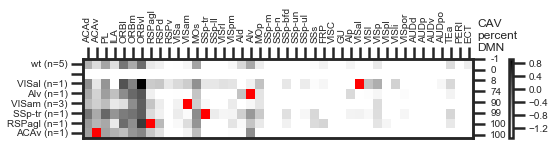

<h2>ACAd</h2>

11


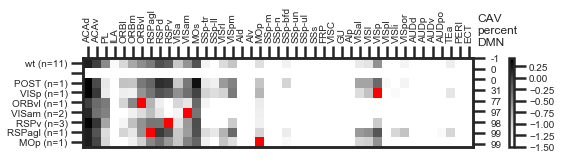

<h2>ENTm</h2>

6


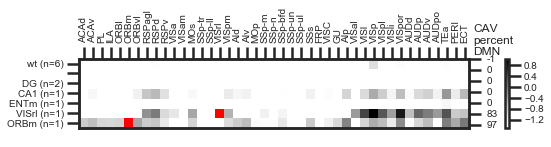

<h2>MD</h2>

12


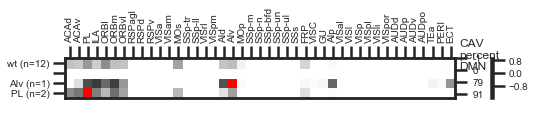

<h2>RSPagl</h2>

7


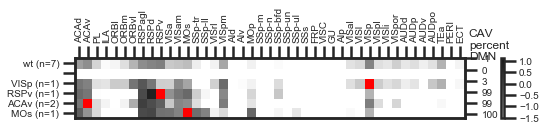

<h2>ENTl</h2>

11


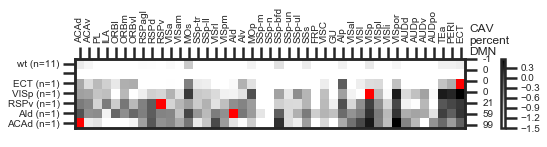

<h2>ECT</h2>

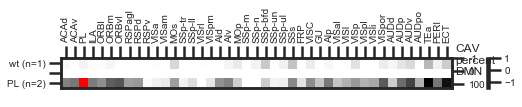

<h2>RSPd</h2>

3


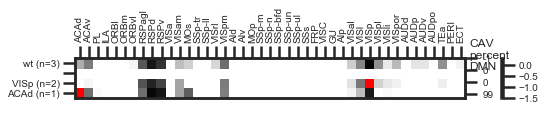

<h2>AM</h2>

2


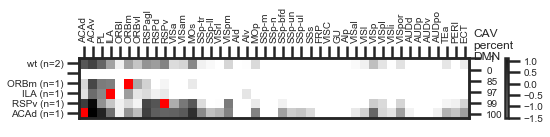

<h2>ORBm</h2>

2


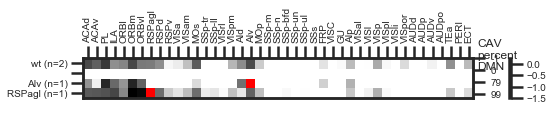

<h2>VISam</h2>

5


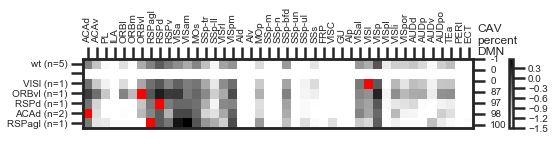

<h2>AIv</h2>

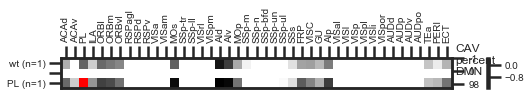

<h2>SSp-tr</h2>

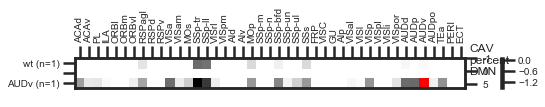

<h2>VISli</h2>

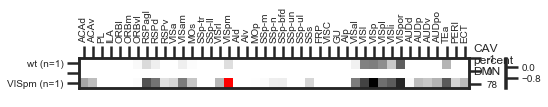

<h2>PL</h2>

4


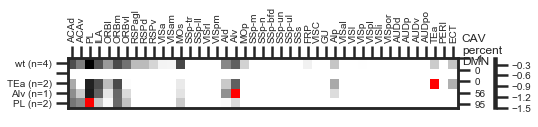

<h2>ILA</h2>

3


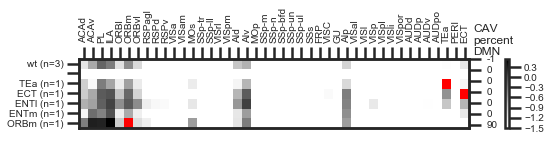

<h2>RE</h2>

2


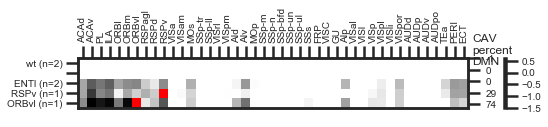

<h2>VISpm</h2>

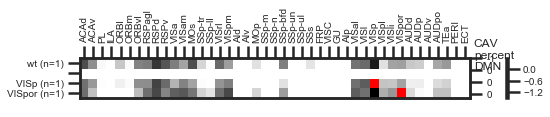

<h2>VISa</h2>

2


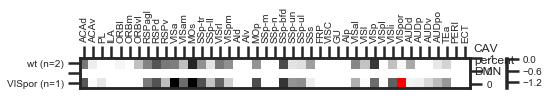

<h2>AV</h2>

2


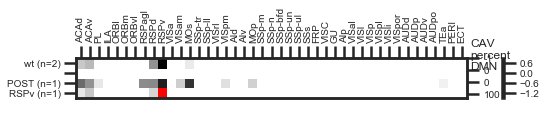

<h2>VISpl</h2>

4


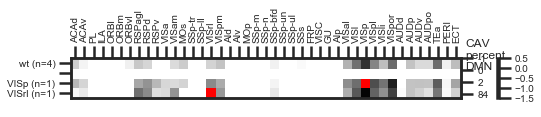

<h2>VISrl</h2>

4


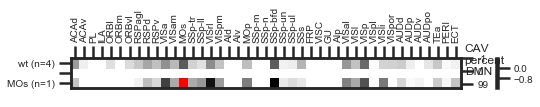

<h2>SSp-ll</h2>

2


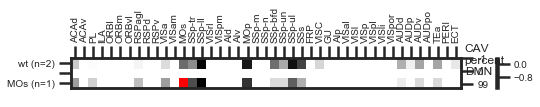

<h2>VISal</h2>

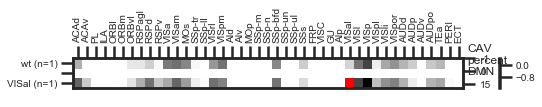

<h2>TEa</h2>

2


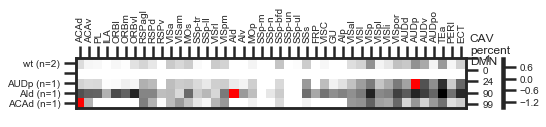

<h2>VISpor</h2>

2


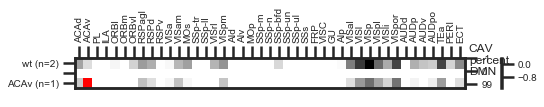

<h2>CLA</h2>

3


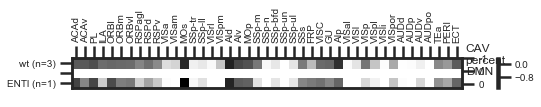

In [14]:
threshold = -1.5 #threshold is applied to log10 value
average=False
for structure in dat['source'].unique():
    '''
    if structure == 'RSPv r':
        display(Markdown('<h2>{}</h2>'.format(structure)))
        #print('thresholded at %s'%threshold)
        source_dat = dat[dat['id'].isin(rostral_rspv)]
        td_dat = source_dat[['id', 'primary_target_acronym_segmentation']]
        wt_ids = np.unique(source_dat['nearest_wt_id'])
        if len(wt_ids) > 1:
            average = True
        make_projection_matrix(structure, td_dat, wt_ids, average, threshold)
    elif structure == 'ACAd-1':
        display(Markdown('<h2>{}</h2>'.format(structure)))
        #print('thresholded at %s'%threshold)
        source_dat = dat[dat['id'].isin(ACAd1)]
        td_dat = source_dat[['id', 'primary_target_acronym_segmentation']]
        wt_ids = np.unique(source_dat['nearest_wt_id'])
        if len(wt_ids) > 1:
            average = True
        make_projection_matrix(structure, td_dat, wt_ids, average, threshold)
    elif structure == 'ACAd-2':
        display(Markdown('<h2>{}</h2>'.format(structure)))
        #print('thresholded at %s'%threshold)
        source_dat = dat[dat['id'].isin(ACAd2)]
        td_dat = source_dat[['id', 'primary_target_acronym_segmentation']]
        wt_ids = np.unique(source_dat['nearest_wt_id'])
        if len(wt_ids) > 1:
            average = True
        make_projection_matrix(structure, td_dat, wt_ids, average, threshold)
    elif structure == 'ACAd-3':
        display(Markdown('<h2>{}</h2>'.format(structure)))
        #print('thresholded at %s'%threshold)
        source_dat = dat[dat['id'].isin(ACAd3)]
        td_dat = source_dat[['id', 'primary_target_acronym_segmentation']]
        wt_ids = np.unique(source_dat['nearest_wt_id'])
        if len(wt_ids) > 1:
            average = True
        make_projection_matrix(structure, td_dat, wt_ids, average, threshold)
    '''
    if structure == 'dorsal RSPv c':
        display(Markdown('<h2>{}</h2>'.format(structure)))
        #print('thresholded at %s'%threshold)
        source_dat = dat[dat['id'].isin(dorsal_rspvc)]
        td_dat = source_dat[['id', 'primary_target_acronym_segmentation']]
        wt_ids = np.unique(source_dat['nearest_wt_id'])
        if len(wt_ids) > 1:
            average = True
        make_projection_matrix(structure, td_dat, wt_ids, average, threshold)
    elif structure == 'matched RSPv c':
        display(Markdown('<h2>{}</h2>'.format(structure)))
        #print('thresholded at %s'%threshold)
        source_dat = dat[dat['id'].isin(matched_rspvc)]
        td_dat = source_dat[['id', 'primary_target_acronym_segmentation']]
        wt_ids = np.unique(source_dat['nearest_wt_id'])
        if len(wt_ids) > 1:
            average = True
        make_projection_matrix(structure, td_dat, wt_ids, average, threshold)
    else:
        display(Markdown('<h2>{}</h2>'.format(structure)))
        source_dat = dmn_score[dmn_score['source'] == structure]
        td_dat = dmn_score[dmn_score['source'] == structure][['image_series_id', 'target_by_projection']]
        wt_ids = np.unique(dat[dat['source'] == structure]['match_id'])
        if len(wt_ids) > 1:
            print(len(wt_ids))
        average = True
        make_projection_matrix(structure, td_dat, wt_ids, True, threshold)

In [ ]:
threshold = -2.5 #threshold is applied to log10 value
for structure in dat['source'].unique():
    if structure in hipp:
        display(Markdown('<h2>{}</h2>'.format(structure)))
        print('thresholded at %s'%threshold)
        source_dat = dat[dat['source'] == structure]
        td_dat = source_dat[['id', 'primary_target_acronym_segmentation']]
        wt_ids = np.unique(source_dat['nearest_wt_id'])
        if len(wt_ids) > 1:
            average = True
        make_projection_matrix(structure, td_dat, wt_ids, average, threshold)

In [ ]:
threshold = -2.5 #threshold is applied to log10 value
for structure in dat['source'].unique():
    if structure in thal:
        source_structure = structure
        display(Markdown('<h2>{}</h2>'.format(source_structure)))
        print('thresholded at %s'%threshold)
        source_dat = dat[dat['source'] == source_structure]
        td_dat = source_dat[['id', 'primary_target_acronym_segmentation']]
        wt_ids = np.unique(source_dat['nearest_wt_id'])
        if len(wt_ids) > 1:
            average = True
        make_projection_matrix(source_structure, td_dat, wt_ids, average, threshold)

In [32]:
dmn_dat = pd.read_csv(r'/Users/jenniferwh/Dropbox/DMN data/Figure 4/figure_4_notebook_new/all_CAV_DMN_projections_coefficients_structures_thresholded.csv')

IOError: File /Users/jenniferwh/Dropbox/DMN data/Figure 4/figure_4_notebook_new/all_CAV_DMN_projections_coefficients_structures_thresholded.csv does not exist

In [ ]:
dmn_dat.keys()

In [ ]:
dmn_dat[(dmn_dat['source structure abbreviation'] == 'ENTm') & (dmn_dat['primary target acronym'] == 'ORBm')][[
    'id', 'source structure abbreviation', 'primary target acronym', 'projection dmn fraction CAV removed',
    'DMN coefficient CAV removed']]

In [ ]:
dmn_dat[(dmn_dat['source structure abbreviation'] == 'ENTl') & (dmn_dat['primary target acronym'] == 'RSPv')][[
    'id', 'source structure abbreviation', 'primary target acronym', 'projection dmn fraction CAV removed',
    'DMN coefficient CAV removed']]

In [ ]:
dmn_dat.sort_values(by = 'dmn structures proj fraction', ascending=False)[[
    'id', 'source structure abbreviation', 'primary target acronym', 'projection dmn fraction CAV removed',
    'dmn structures proj fraction', 'DMN coefficient CAV removed']]